In [1]:
%matplotlib inline

In [2]:
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from dask import compute, persist
import dask.dataframe as dd

from dask.distributed import Client, config

In [3]:
pd.options.display.max_rows = 10
pd.options.display.max_columns = 60
pd.options.display.float_format = lambda s: "{:,.2f}".format(s)

In [4]:
client = Client(processes=False)
# client = Client(config['scheduler-address'])  # For remote
client

Client Scheduler: inproc://192.168.7.20/77496/1 Dashboard: http://localhost:8787,Cluster Workers: 1 Cores: 8 Memory: 17.18 GB


[Pandas](https://pandas.pydata.org) is an open-source Python library for doing working with tabular datasets.
It provides an in-memory `DataFrame`, a container for heterogenous, tabular data. Pandas provides many methods for wrangling your data into shape.

In this article we'll attempt to analyze a larger-than-memory dataset. Since a single pandas dataframe can't be larger than memory, we'll need to adjust our workflow to cope. We'll then perform the same analysis with `dask.dataframe`, which gives us a pandas-like API for analyzing large datasets in parallel.

Our examples will work with data from the [Federal Elections Commision](http://classic.fec.gov/finance/disclosure/ftpdet.shtml). The dataset
includes multiple tables, with information on dontations from individuals, committees that accpet those donations, and what the money is spent on, and candidates running for office. Each table is split by election cycle (2007-2008, 2009-2010, ...).

Each record in the individual donations table represents a single donation from an individual to a committee. We'll look at the date and amount of the donation and some information on the donor.

In [5]:
data = "data"
storage_options = {}

# For remote cluster
# data = "gcs://dask-demo-benchmarks"
# storage_options = {'token': 'cloud', 'project': 'dask-demo'}

In [7]:
individual_cols = ['cmte_id', 'entity_tp', 'employer', 'occupation',
                   'transaction_dt', 'transaction_amt']

indiv = pd.read_parquet("data/indiv-08.parq", columns=individual_cols,
                        engine="fastparquet")
indiv.head()

,cmte_id,entity_tp,employer,occupation,transaction_dt,transaction_amt
0,C00371021,IND,THE BEAL COMPANIES LLC,REAL ESTATE DEVELOPER,2007-05-22,1000
1,C00371021,IND,BESWICK ENGINEERING CO. INC.,PRESIDENT,2007-05-22,500
2,C00371021,IND,SELF-EMPLOYED,PHYSICIAN,2007-05-21,250
3,C00371021,IND,RETIRED,None,2007-05-08,2300
4,C00371021,IND,RETIRED/N/A,None,2007-06-12,250


Pandas makes most common operations one-liners. For example, we can compute the count of each occupation and select just the 100 most common.

In [15]:
indiv['occupation'].value_counts().nlargest(100)

RETIRED               472458
ATTORNEY              279898
HOMEMAKER             111925
PRESIDENT             104568
PHYSICIAN             102005
                       ...  
CONSTRUCTION            3009
LETTER CARRIER          2911
PRODUCER                2910
INSURANCE BROKER        2902
INVESTMENT ADVISOR      2818
Name: occupation, Length: 100, dtype: int64

While my laptop can read in the file for 2008, it can't read the full dataset spanning 2008-2016 all at once. The full dataset is larger than the RAM on my computer. In this situation, pandas users will typically turn to chunking. We will

1. Create a global `total_counts` variable that contains the counts from all of the files processed so far
2. Read in a file
3. Compute a temporary variable `counts` with the counts for just this file
4. Add that temporary `counts` into the global `total_counts`
5. Select the 100 largest with `.nlargest`

In [17]:
files = glob.glob("data/indiv-*.parq")
files

['data/indiv-08.parq',
 'data/indiv-10.parq',
 'data/indiv-12.parq',
 'data/indiv-14.parq',
 'data/indiv-16.parq']

In [12]:
%%time
total_counts = pd.Series()
for year in files:
    df = pd.read_parquet(year, columns=individual_cols,
                         engine="fastparquet")
    counts = df.occupation.value_counts()
    total_counts = total_counts.add(counts, fill_value=0)
    

total_counts = total_counts.nlargest(100).sort_values(ascending=False)
total_counts

CPU times: user 34.1 s, sys: 5.24 s, total: 39.3 s
Wall time: 39.4 s


We've effectively implemented a MapReduce version of `value_counts`. We map `pd.read_parquet` and `pandas.Series.value_counts` over each file, giving the counts per occupation for each
file. We reduce those by summing all the intermediate counts into the `total_counts` Series.

Writing all the MapReduce boilerplate is possible, but tedious; we've lost our
nice one-line `df.column.value_counts` in exchange for an algorithm that works
on larger-than-memory datasets. We accomplished the final outcome by breaking our larger-than-memory problem into many smaller (in-memory) problems.

`dask.dataframe` is able to do that for you. It let's you write pandas-like code for working with larger than memory datasets in parallel.

## `dask.dataframe`

[`dask.dataframe`](http://dask.pydata.org/en/latest/dataframe.html) is one of dask's *collections*. The collections provide APIs that mimic popular Python libraries ([`dask.array`](http://dask.pydata.org/en/latest/array.html) for large NumPy arrays, `dask.dataframe` for large pandas `DataFrames`, [`dask.bag`](http://dask.pydata.org/en/latest/bag.html) for large Python collections).

We'll create a dask `DataFrame` containing the entire dataset using dask's verison of `read_parquet`, which works with many files at once.

In [18]:
import dask.dataframe as dd
from dask import compute

indiv = dd.read_parquet(f'{data}/indiv-*.parq',
                        columns=individual_cols,
                        engine="fastparquet",
                        storage_options=storage_options)
indiv

,cmte_id,entity_tp,employer,occupation,transaction_dt,transaction_amt
npartitions=5,,,,,,
,object,category[unknown],object,object,datetime64[ns],int64
,...,...,...,...,...,...
...,...,...,...,...,...,...
,...,...,...,...,...,...
,...,...,...,...,...,...


Dask collections are *lazy*. They don't actually execute anything until you ask for the result. So far, `read_parquet` has just read in some metadata like the column names and types. But you can still operate on dask `DataFrame`s just like a normal pandas `DataFrame`. For example, we'll use the exact same pandas code as above for computing the 100 most common occupations.

In [14]:
counts = indiv.occupation.value_counts().nlargest(100)
counts

Dask Series Structure:
npartitions=1
    int64
      ...
Name: occupation, dtype: int64
Dask Name: series-nlargest-agg, 18 tasks

When you call a method like `.value_couts` dask manipulates a *task graph* rather than computing the result immediately. `counts` contains a task graph with all the information needed to compute the counts when asked.  We'll discuss task graphs later, but for now let's visualize it:

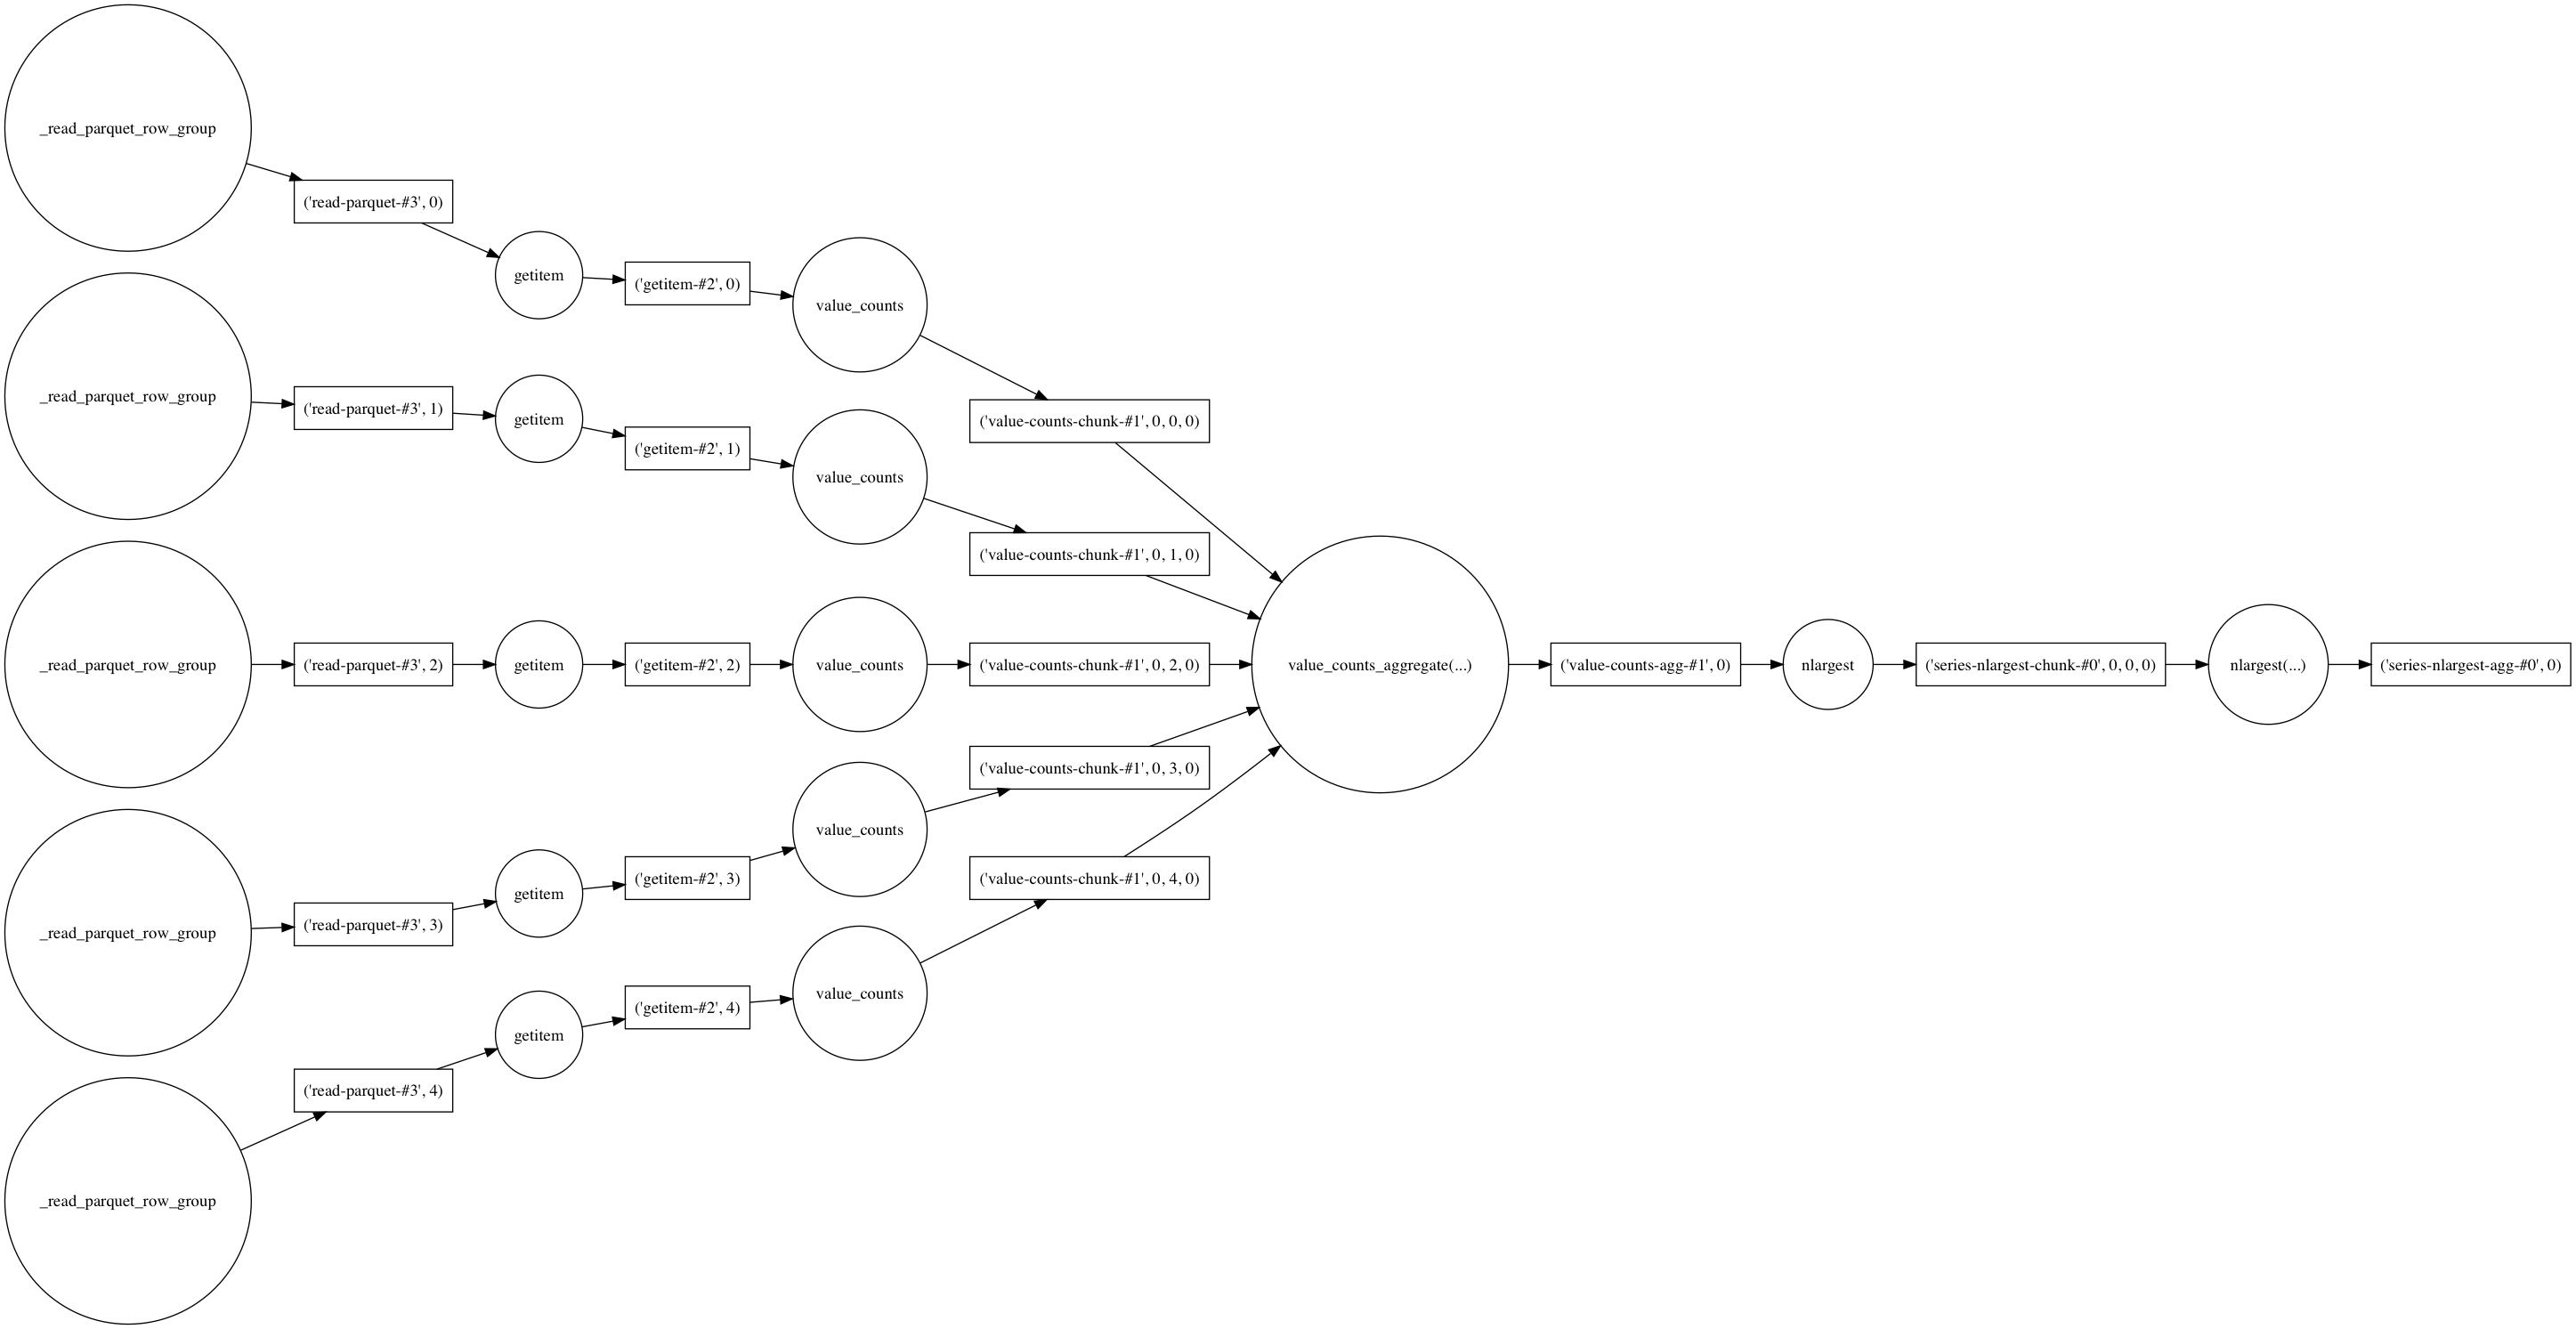

In [15]:
counts.visualize(filename='value-counts-full', rankdir='LR')

Here's a slightly simplified version for just 2008 and 2010, so that things are a bit easier to read. (we'd only show one)

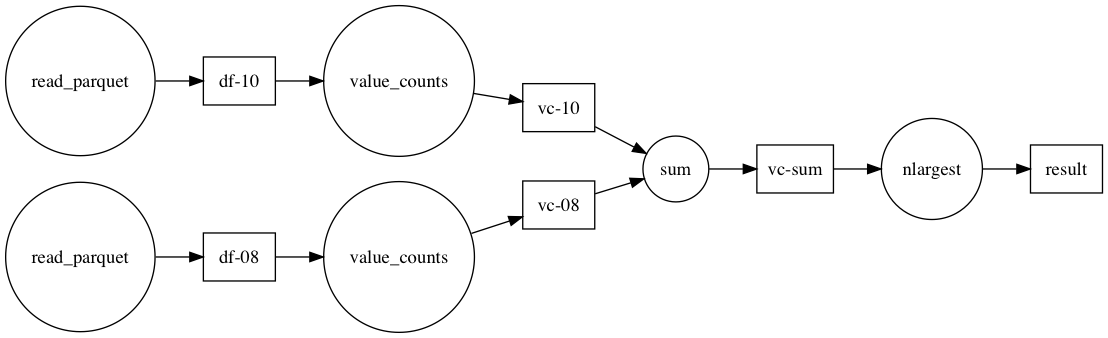

In [16]:
import dask

d = {
    'df-08': (pd.read_parquet, '2008.parq'),
    'df-10': (pd.read_parquet, '2010.parq'),
    'vc-08': (pd.Series.value_counts, 'df-08'),
    'vc-10': (pd.Series.value_counts, 'df-10'),
    'vc-sum': (sum, 'vc-08', 'vc-10'),
    'result': (pd.Series.nlargest, 'vc-sum'),
}
dask.visualize(d, rankdir="LR")

Looking through the structure of the graph, you can see dask has done all the
MapReduce-style work for us. It's read in each file independently
(`read_parquet`), obtained the intermediate counts (`value_counts`), summed those together
(`sum`), and selected the 100 largest (`nlargest`). We've successfully done a larger-than-memory `value_counts` in a single line of pandas-like code.

When you need the actual value, the graph can be executed by calling
`dask.compute` or the `.compute` method.

In [15]:
%time counts.compute()

CPU times: user 18.4 s, sys: 3.24 s, total: 21.7 s
Wall time: 19.8 s


RETIRED                    4769520
NOT EMPLOYED               2656988
ATTORNEY                   1340434
PHYSICIAN                   659082
HOMEMAKER                   494187
                            ...   
CHIEF EXECUTIVE OFFICER      26551
SURGEON                      25521
EDITOR                       25457
OPERATOR                     25151
ORTHOPAEDIC SURGEON          24384
Name: occupation, Length: 100, dtype: int64

Calling `compute` hands the task graph off to one of dask's [*schedulers*](http://dask.pydata.org/en/latest/scheduler-overview.html). Schedulers are responsible for computing task graphs and returning concrete results. It's up to the scheduler to choose which tasks to run when, and how they should be run. You can use the cores on your laptop with the threaded scheduler or the machines in a cluster with the distributed scheduler (the default for `dask.dataframe` is the threaded scheduler, though dask makes it easy to pick manually [Choosing Schedulers](http://dask.pydata.org/en/latest/scheduler-choice.html)).

So that's a high-level summary of dask:

![](http://dask.pydata.org/en/latest/_images/collections-schedulers.png)

1. Various collections collections like `dask.dataframe` and `dask.array`
   provide users familiar APIs for working with large datasets.
2. Computations are represented as a task graph. These graphs could be built by
   hand, or more commonly built by one of the collections.
3. Dask schedulers run task graphs in parallel (potentially distributed across
   a cluster), reusing libraries like NumPy and pandas to do the computations.

## Additional Details on Dask

One of the primary goals of dask is to parallelize the existing scientific
python stack. Most of these libraries (most notably NumPy and pandas) can only
operate on datasets that fit in RAM, and do so with only single core of a single
CPU of a single machine.

Rather than attempting to rewrite NumPy or pandas to be parallel-native, dask
reuses those libraries for what they're great at: in-memory containers and
computation engines. Dask enables analysis of large datasets (in parallel) by
breaking the problem into many smaller problems and using NumPy, pandas, or
other existing libraries to do the computation of the smaller problems. Dask
coordinates everything by representing the smaller problems in a task graph.

Our `value_counts` example fits in the MapReduce pattern. But it's important to emphasize that `dask` isn't limited to simple map-reduce type computations. Let's continue exploring these datasets.

In [18]:
# indiv = indiv.persist()

We can compute summary statistics like the average mean and standard deviation of the transaction amount:

In [19]:
avg_transaction = indiv.transaction_amt.mean()

We can answer questions like "Which employer's employees donated the most?"

In [20]:
total_by_employee = (
    indiv.groupby('employer')
        .transaction_amt.sum()
        .nlargest(10)
)

Or "what is the average amount donated per occupation?"

In [21]:
avg_by_occupation = (
    indiv.groupby("occupation")
        .transaction_amt.mean()
        .nlargest(10)
)

Since dask is lazy, we haven't actually computed anything.

In [22]:
total_by_employee

Dask Series Structure:
npartitions=1
    int64
      ...
Name: transaction_amt, dtype: int64
Dask Name: series-nlargest-agg, 13 tasks

`avg_transaction`, `avg_by_occupation` and `total_by_employee` are three separate computations (they have different task graphs), but we know they share some structure: they're all reading in the same data, they might select the same subset of columns, and so on. Dask is able to avoid redudant computation when you use the top-level `dask.compute` function.

In [23]:
%%time
avg_transaction, by_employee, by_occupation = compute(
    avg_transaction, total_by_employee, avg_by_occupation
)

CPU times: user 58.5 s, sys: 14.6 s, total: 1min 13s
Wall time: 1min 1s


In [24]:
avg_transaction

566.0899206077507

In [25]:
by_employee

employer
RETIRED                1019973117
SELF-EMPLOYED           834547641
SELF                    537402882
SELF EMPLOYED           447363032
NONE                    418011322
HOMEMAKER               355195126
NOT EMPLOYED            345770418
FAHR, LLC               166679844
CANDIDATE                75186830
ADELSON DRUG CLINIC      53358500
Name: transaction_amt, dtype: int64

In [26]:
by_occupation

occupation
CHAIRMAN CEO & FOUNDER                   1,023,333.33
PAULSON AND CO., INC.                    1,000,000.00
CO-FOUNDING DIRECTOR                       875,000.00
CHAIRMAN/CHIEF TECHNOLOGY OFFICER          750,350.00
CO-FOUNDER, DIRECTOR, CHIEF INFORMATIO     675,000.00
CO-FOUNDER, DIRECTOR                       550,933.33
MOORE CAPITAL GROUP, LP                    500,000.00
PERRY HOMES                                500,000.00
OWNER, FOUNDER AND CEO                     500,000.00
CHIEF EXECUTIVE OFFICER/PRODUCER           500,000.00
Name: transaction_amt, dtype: float64

Things like filtering work well. Let's find the 10 most common occupations and filter the dataset down to just those.

In [27]:
top_occupations = (
    indiv.occupation.value_counts()
        .nlargest(10).index
).compute()
top_occupations

Index(['RETIRED', 'NOT EMPLOYED', 'ATTORNEY', 'PHYSICIAN', 'HOMEMAKER',
       'PRESIDENT', 'PROFESSOR', 'CONSULTANT', 'EXECUTIVE', 'ENGINEER'],
      dtype='object')

We'll filter the raw records down to just the ones from those occupations. Then we'll compute a few summary statistics on the transaction amounts for each group.

In [43]:
donations = (
    indiv[indiv.occupation.isin(top_occupations)]
        .groupby("occupation")
        .transaction_amt
        .agg(['count', 'mean', 'sum', 'max'])
)

In [44]:
total_avg, occupation_avg = compute(indiv.transaction_amt.mean(),
                                    donations['mean'])

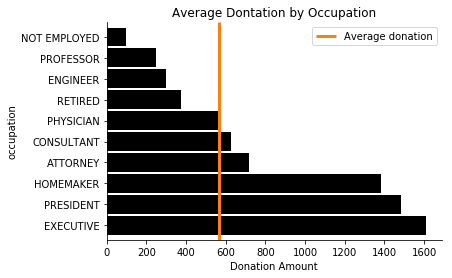

In [45]:
ax = occupation_avg.sort_values(ascending=False).plot.barh(color='k', width=0.9);
lim = ax.get_ylim()
ax.vlines(total_avg, *lim, color='C1', linewidth=3)
ax.legend(['Average donation'])
ax.set(xlabel="Donation Amount", title="Average Dontation by Occupation")
sns.despine()

Dask inherit's all of pandas great time-series support. We can get the total amount donated per day using a [`resample`](https://pandas.pydata.org/pandas-docs/stable/timeseries.html#resampling) (a time-series-specific version of groupby).

In [46]:
daily = (
    indiv[['transaction_dt', 'transaction_amt']].dropna()
        .set_index('transaction_dt')['transaction_amt']
        .resample("D")
        .sum()
).compute()
daily

1916-01-23   1,000.00
1916-01-24        nan
1916-01-25        nan
1916-01-26        nan
1916-01-27        nan
               ...   
2201-05-29        nan
2201-05-30        nan
2201-05-31        nan
2201-06-01        nan
2201-06-02   2,000.00
Name: transaction_amt, Length: 104226, dtype: float64

It seems like we have some bad data. We'll filter it down to the real subset before plotting.

In [47]:
subset = daily.loc['2011':'2016']

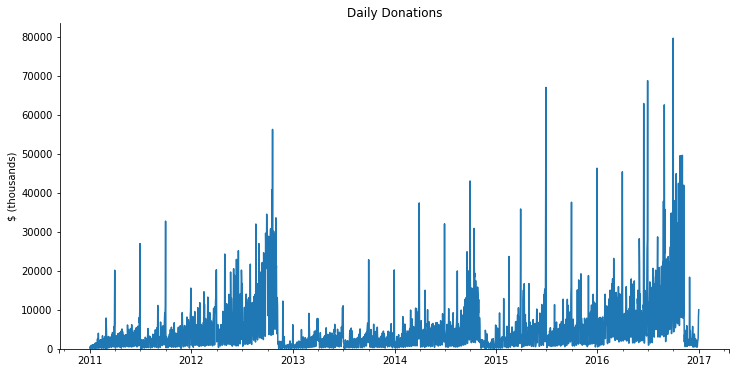

In [48]:
ax = subset.div(1000).plot(figsize=(12, 6))
ax.set(ylim=0, title="Daily Donations", ylabel="$ (thousands)",)
sns.despine();

## Joining

Dask supports joining together multiple datasets.

Individual dontations are made to *committees*. Committees are what make the actual expenditures (buying a TV ad).

Some committees are directly tied to a candidate (this are campaign committees). Other committess are tied to a group (like the Republican National Committee). Either may be tied to a party.

Let's read in the committees:

In [49]:
committee_cols = ['cmte_id', 'cmte_nm', 'cmte_tp', 'cmte_pty_affiliation']
cm = dd.read_parquet(f"{data}/cm-*.parq",
                     columns=committee_cols,
                     storage_options=storage_options).compute()

# Some committees change thier name, but the ID stays the same
cm = cm.groupby('cmte_id').last()
cm

,cmte_nm,cmte_tp,cmte_pty_affiliation
cmte_id,,,
C00000042,ILLINOIS TOOL WORKS INC. FOR BETTER GOVERNMENT...,Q,None
C00000059,HALLMARK CARDS PAC,Q,UNK
C00000422,AMERICAN MEDICAL ASSOCIATION POLITICAL ACTION ...,Q,None
C00000489,D R I V E POLITICAL FUND CHAPTER 886,N,None
C00000547,KANSAS MEDICAL SOCIETY POLITICAL ACTION COMMITTEE,Q,UNK
...,...,...,...
C90017237,ORGANIZE NOW,I,None
C90017245,FRANCISCO AGUILAR,I,None
C90017336,"LUDWIG, EUGENE",I,None


We'll use `dd.merge`, which is analogous to `pd.merge` for joining a dask `DataFrame` with a pandas or dask `DataFrame`.

In [50]:
indiv = indiv[(indiv.transaction_dt >= pd.Timestamp("2007-01-01")) &
              (indiv.transaction_dt <= pd.Timestamp("2018-01-01"))]

df2 = dd.merge(indiv, cm.reset_index(), on='cmte_id')
df2

,cmte_id,entity_tp,employer,occupation,transaction_dt,transaction_amt,cmte_nm,cmte_tp,cmte_pty_affiliation
npartitions=5,,,,,,,,,
,object,category[unknown],object,object,datetime64[ns],int64,object,object,object
,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...


Now we can find which party raised more over the course of each election. We'll group by the day and party and sum the transaction amounts.

In [51]:
party_donations = (
    df2.groupby([df2.transaction_dt, 'cmte_pty_affiliation'])
       .transaction_amt.sum()
).compute().sort_index()

We'll filter that down to just Republican and Democrats and plot.

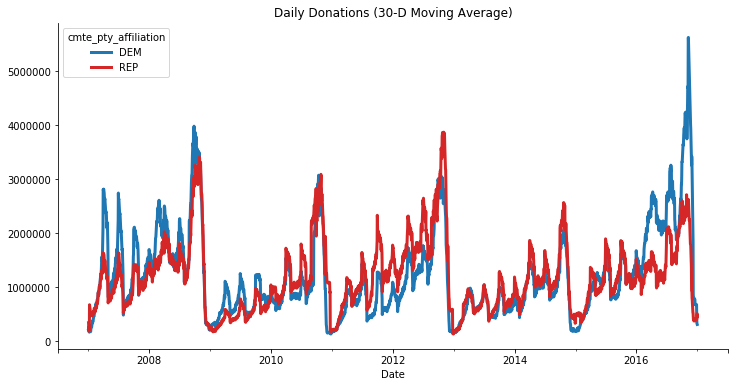

In [52]:
ax = (
    party_donations.loc[:, ['REP', 'DEM']]
        .unstack("cmte_pty_affiliation").iloc[1:-2]
        .rolling('30D').mean().plot(color=['C0', 'C3'], figsize=(12, 6),
                                    linewidth=3)
)
sns.despine()
ax.set(title="Daily Donations (30-D Moving Average)", xlabel="Date");

This is a pleasant workflow of analyzing medium-sized datasets (in the 10s-100s of GB) interactively. Everything here will run on a single machine, reading in from disk as nescessary. With a cluster, we can persist everything in distributed RAM, avoiding the IO costs. You can write pandas-like code to filter and summarize the full dataset down to a region of interest, and use the usual tools like matplotlib to visualize the data.